In [1]:
#!rm -r build
#!rm nice/*.so
#!rm nice/transformers/*.so
!python3 setup.py build_ext --inplace

running build_ext
copying build/lib.linux-x86_64-3.6/nice/naive.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/nice_utilities.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/packing.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/radial_basis.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/rascal_coefficients.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/spherical_coefficients.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/spherical_harmonics.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/test_parallel.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/thresholding.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/unrolling_individual_pca.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x

In [2]:
'''import sys
sys.path.insert(0, 'nice')
'''
#os.environ['OMP_NUM_THREADS'] = '24'

import numpy as np
import ase.io as ase_io
from ase import Atoms
import tqdm
import time
import nice
from nice.transformers import *
from nice.rascal_coefficients import get_rascal_coefficients_parallelized
import copy
from matplotlib import pyplot as plt


## Getting coefficients

In [3]:
def process_structures(structures, shift):
    for structure in structures: 
        structure.cell = [2 * shift, 2 * shift, 2 * shift]
        structure.positions += np.asarray((shift, shift, shift))
        structure.pbc=True
        structure.wrap()

In [4]:
structures = ase_io.read('structures.xyz', 
                         index = '0:500')

process_structures(structures, 100)

#process_structures(structures_val)


In [5]:
HYPERS = {
'interaction_cutoff': 6.3,
'max_radial': 5,
'max_angular': 5,
'gaussian_sigma_type': 'Constant',
'gaussian_sigma_constant': 0.05,
'cutoff_smooth_width': 0.3,
'radial_basis': 'GTO',
'global_species': [1, 6],
'expansion_by_species_method': 'user defined'
}
    

First of all we need to get spherical expansion coefficients in proper format. For this purpose I prepared simple wrapper on the rascal to get them in parallel:

In [6]:
coefficients = get_rascal_coefficients_parallelized(structures, HYPERS)

100%|██████████| 2/2 [00:00<00:00, 271.50it/s]


In [7]:
print(type(coefficients))
print(coefficients[1].shape)
print(coefficients[6].shape)

<class 'dict'>
(2000, 10, 6, 11)
(500, 10, 6, 11)


Result is the dictionary, where keys are atomic species, 1 - is H atomic number, 6 is C atomic number. Shapes of the coefficients are [env index, radial/specie index, l, m]. In order to use this function  'expansion_by_species_defined' must be user defined since output must be uniform. These properties are set automatically in the hypers dictionary

In [8]:
HYPERS = {
'interaction_cutoff': 6.3,
'max_radial': 5,
'max_angular': 5,
'gaussian_sigma_type': 'Constant',
'gaussian_sigma_constant': 0.05,
'cutoff_smooth_width': 0.3,
'radial_basis': 'GTO',
}
coefficients = get_rascal_coefficients_parallelized(structures, HYPERS)    

print(type(coefficients))
print(coefficients[1].shape)
print(coefficients[6].shape)

100%|██████████| 2/2 [00:00<00:00, 294.35it/s]

<class 'dict'>
(2000, 10, 6, 11)
(500, 10, 6, 11)


If we would try to set this field to the other value it would raise ValueError:

In [9]:
HYPERS = {
'interaction_cutoff': 6.3,
'max_radial': 5,
'max_angular': 5,
'gaussian_sigma_type': 'Constant',
'gaussian_sigma_constant': 0.05,
'cutoff_smooth_width': 0.3,
'expansion_by_species_method': 'environment wise',
'radial_basis': 'GTO'
}
coefficients = get_rascal_coefficients_parallelized(structures, HYPERS)    

print(type(coefficients))
print(coefficients[1].shape)
print(coefficients[6].shape)

ValueError: for proper packing spherical expansion coefficients into [env index, radial/specie index, l, m] shape output should be uniform, thus 'expansion_by_species_method' must be 'user defined'

and if given global species are insufficients it would add all missing species:

In [10]:
HYPERS = {
'interaction_cutoff': 6.3,
'max_radial': 5,
'max_angular': 5,
'gaussian_sigma_type': 'Constant',
'gaussian_sigma_constant': 0.05,
'cutoff_smooth_width': 0.3,
'radial_basis': 'GTO',
'global_species': [1, 117, 42],
'expansion_by_species_method': 'user defined'
}
    
coefficients = get_rascal_coefficients_parallelized(structures, HYPERS)    

print(type(coefficients))
print(coefficients[1].shape)
print(coefficients[6].shape)

/home/pozdn/psi4conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: atom with type 6 is presented in the dataset but it is not listed in the global_species, adding it
  del sys.path[0]
100%|██████████| 4/4 [00:00<00:00, 352.15it/s]

<class 'dict'>
(2000, 20, 6, 11)
(500, 20, 6, 11)


Note the increase dimension for the radial/specie index because of additional 117 and 42 atomic types

Let's calculate once again coefficients without global species for future manipulation

In [11]:
HYPERS = {
'interaction_cutoff': 6.3,
'max_radial': 5,
'max_angular': 5,
'gaussian_sigma_type': 'Constant',
'gaussian_sigma_constant': 0.05,
'cutoff_smooth_width': 0.3,
'radial_basis': 'GTO'
}
coefficients = get_rascal_coefficients_parallelized(structures, HYPERS)    
print(coefficients[1].shape)

100%|██████████| 2/2 [00:00<00:00, 298.13it/s]

(2000, 10, 6, 11)


It may be a good idea to normalize coefficients to the integral of the density within given environment, which is given by the summation of the squared l = 0, m = 0 coefficients. It is done by the following function:

In [12]:
def normalize_coefficients(coefficients):
    for key in coefficients.keys():
        coefficients[key] = coefficients[key] / np.sqrt(np.sum(coefficients[key][:, :, 0, 0] ** 2, axis = 1))[:, np.newaxis, np.newaxis, np.newaxis]

In [13]:
print(coefficients[6][0, 0, 0, 0])
normalize_coefficients(coefficients)
print(coefficients[6][0, 0, 0, 0])

5.733729249698362e-06
0.06221528852749003


I decided not to include this into the nice main code, because I think that this should be on librascal side. I. e. one additional parameter to hypers. (may be some sqrt or not sqrt of 4 Pi should be inserted in the formula, and also it would be nice to see options for either global normalization either normalization per specie)

## Data structure

In the implementation I keep the covariants which do not change under the inversion and the covariants which change sign separatelly. The first I call even the second I call odd. So, the first thing to do is to split coefficients into these two groups:

In [14]:
data_even_1, data_odd_1  = InitialTransformer().transform(coefficients[6])

I have a class to store the data

In [15]:
print(data_even_1)

fields are covariants_, actual_sizes_, importances_

In [16]:
print(data_even_1.covariants_.shape)
print(data_even_1.actual_sizes_)
print(data_even_1.importances_, end = "\n\n")

print(data_odd_1.covariants_.shape)
print(data_odd_1.actual_sizes_)
print(data_odd_1.importances_, end = "\n\n")

(500, 10, 6, 11)
[10, 0, 10, 0, 10, 0]
None

(500, 10, 6, 11)
[0, 10, 0, 10, 0, 10]
None



This class supports slicing in the environment index:

In [17]:
data_even_small = data_even_1[0:20]
print(data_even_small.covariants_.shape)
print(data_even_small.actual_sizes_)
print(data_even_small.importances_)

(20, 10, 6, 11)
[10, 0, 10, 0, 10, 0]
None


Also this class has a method to get invariants:

In [18]:
invariants = data_even_1.get_invariants()
print(invariants.shape)

invariants = data_odd_1.get_invariants()
print(invariants.shape)

(500, 10)
(500, 0)


I think that the names tell for themselves. Importances are the arrays which would tell how important this particular covariant is and this field would be not None after the pca transformation.

## Compressors

 Let's do it:

In [19]:
pca = IndividualLambdaPCAsBoth(n_components = 9)
pca.fit(data_even_1, data_odd_1)
tmp_even, tmp_odd = pca.transform(data_even_1, data_odd_1)
print(tmp_even.covariants_.shape)
print(tmp_even.actual_sizes_)

(500, 9, 6, 11)
[9 0 9 0 9 0]


This class will do individual pca over different lambda channels. Both means for both even and odd data.
One common thing about all compressors (pca) and purifiers is the behaviour of n_components parameter. If it is not specified (None) than the pca still will be done with the number of components equal to the number of covariants for each individual lambda:

In [20]:
artificial_even, artificial_odd = copy.deepcopy(data_even_1), copy.deepcopy(data_odd_1)
artificial_even.actual_sizes_[0] = 3
artificial_even.actual_sizes_[2] = 6
print(artificial_even.actual_sizes_)

[3, 0, 6, 0, 10, 0]


In [21]:
pca = IndividualLambdaPCAsBoth()
pca.fit(artificial_even, artificial_odd)
tmp_even, tmp_odd = pca.transform(artificial_even, artificial_odd)
print(tmp_even.covariants_.shape)
print(tmp_even.actual_sizes_)

print(tmp_odd.covariants_.shape)
print(tmp_odd.actual_sizes_)

(500, 10, 6, 11)
[ 3  0  6  0 10  0]
(500, 10, 6, 11)
[ 0 10  0 10  0 10]


Also, if it is specified, but the number of components for given lambda channel is less than that number it would keep this number of components:

In [22]:
pca = IndividualLambdaPCAsBoth(n_components = 7)
pca.fit(artificial_even, artificial_odd)
tmp_even, tmp_odd = pca.transform(artificial_even, artificial_odd)
print(tmp_even.covariants_.shape)
print(tmp_even.actual_sizes_)

print(tmp_odd.covariants_.shape)
print(tmp_odd.actual_sizes_)

(500, 7, 6, 11)
[3 0 6 0 7 0]
(500, 7, 6, 11)
[0 7 0 7 0 7]


Another parameter, which also behaves the same way for all compressors and purifiers is num_to_fit. It can be either number either string, like '10x'. The first would mean that pca would use the specified number of data points to fit, even if the total amount of provided data is higher. But data point I mean single double. I. e. for given the number of data points would be (lambda + 1) * number_of_environments. If num_to_fit is the string than the the number of data points to fit would be determined as current number of components multiplier by number in string. Default value is '10x'. It will warn you if the amount of provided data is smaller than one given by num_to_fit and will raise ValueError  if 1) num_to_fit is specified to be so small that it is not possible to fit pca or 2) if amount of provided data is too small to fit pca


In [23]:
pca = IndividualLambdaPCAsBoth(n_components = 7, num_to_fit = 2000)
pca.fit(artificial_even, artificial_odd)
tmp_even, tmp_odd = pca.transform(artificial_even, artificial_odd)
print(tmp_even.covariants_.shape)
print(tmp_even.actual_sizes_)

print(tmp_odd.covariants_.shape)
print(tmp_odd.actual_sizes_)

(500, 7, 6, 11)
[3 0 6 0 7 0]
(500, 7, 6, 11)
[0 7 0 7 0 7]


/home/pozdn/nice/nice/transformers/compressors.py:73: RuntimeWarning: given data is less than desired number of points to fit pca. Desired number of points to fit pca is 2000, while number of vectors is 500, dimensionality of single vector (lambd + 1) is 1, i. e. total number of points is 500. Number of pca components is 7
  warnings.warn("given data is less than desired number of points to fit pca. Desired number of points to fit pca is {}, while number of vectors is {}, dimensionality of single vector (lambd + 1) is {}, i. e. total number of points is {}. Number of pca components is {}".format(num_fit_now, data.covariants_.shape[0], (lambd + 1), data.covariants_.shape[0] * (lambd + 1), n_components_now), RuntimeWarning)
/home/pozdn/nice/nice/transformers/compressors.py:73: RuntimeWarning: given data is less than desired number of points to fit pca. Desired number of points to fit pca is 2000, while number of vectors is 500, dimensionality of single vector (lambd + 1) is 3, i. e. tota

In [24]:
pca = IndividualLambdaPCAsBoth(n_components = 7, num_to_fit = '100x')
pca.fit(artificial_even, artificial_odd)
tmp_even, tmp_odd = pca.transform(artificial_even, artificial_odd)
print(tmp_even.covariants_.shape)
print(tmp_even.actual_sizes_)

print(tmp_odd.covariants_.shape)
print(tmp_odd.actual_sizes_)

(500, 7, 6, 11)
[3 0 6 0 7 0]
(500, 7, 6, 11)
[0 7 0 7 0 7]


/home/pozdn/nice/nice/transformers/compressors.py:73: RuntimeWarning: given data is less than desired number of points to fit pca. Desired number of points to fit pca is 700, while number of vectors is 500, dimensionality of single vector (lambd + 1) is 1, i. e. total number of points is 500. Number of pca components is 7
  warnings.warn("given data is less than desired number of points to fit pca. Desired number of points to fit pca is {}, while number of vectors is {}, dimensionality of single vector (lambd + 1) is {}, i. e. total number of points is {}. Number of pca components is {}".format(num_fit_now, data.covariants_.shape[0], (lambd + 1), data.covariants_.shape[0] * (lambd + 1), n_components_now), RuntimeWarning)


In [25]:
pca = IndividualLambdaPCAsBoth(n_components = 7, num_to_fit = 1)
pca.fit(artificial_even, artificial_odd)
tmp_even, tmp_odd = pca.transform(artificial_even, artificial_odd)
print(tmp_even.covariants_.shape)
print(tmp_even.actual_sizes_)

print(tmp_odd.covariants_.shape)
print(tmp_odd.actual_sizes_)

ValueError: specified parameter num fit (1) is too small to fit pca with number of components 7 

In [26]:
pca = IndividualLambdaPCAsBoth(n_components = 7)
pca.fit(artificial_even[0:2], artificial_odd[0:2])
tmp_even, tmp_odd = pca.transform(artificial_even, artificial_odd)
print(tmp_even.covariants_.shape)
print(tmp_even.actual_sizes_)

print(tmp_odd.covariants_.shape)
print(tmp_odd.actual_sizes_)

ValueError: not enough data to fit pca, number of vectors is 2, dimensionality of single vector (lambd + 1) is 1, i. e. total number of points is 2, while number of components is 7

PCA also estimates feature importances:

In [27]:
pca = IndividualLambdaPCAsBoth(n_components = 9)
pca.fit(data_even_1, data_odd_1)
data_even_1_t, data_odd_1_t = pca.transform(data_even_1, data_odd_1)
print(data_even_1_t.importances_.shape)

(9, 6)


Array is two dimensional, first dimension corresponds to feature index and the second to lambda. Valid elements are [:actual_sizes_[lambd], lambd]

Instance of this class has fields pca.even_pca_.pcas_[:] and pca.odd_pca.pcas_[:] which are instances of class which inherits from sklearn.decomposition.TruncatedSVD. Thus they have explained_variance_, explained_variance_ratio_ and singular_values_. In addition they have importances_ which are subsequently used by ThresholdExpansioner. Importances_ are almost the same as explained_variance_ratio_ with the only difference that they are normalized not to the total variance before pca transformation but to the total variance after. I. e. sum(importance_) is always 1.0

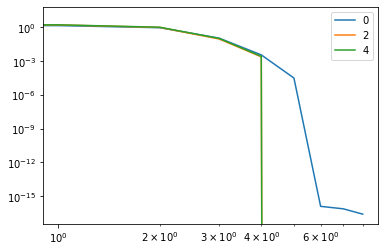

In [28]:
for lambd in range(6):
    if (pca.even_pca_.pcas_[lambd]): #it can be None if input data doens't have any features for this lambda
        plt.plot(pca.even_pca_.pcas_[lambd].singular_values_, label = str(lambd))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

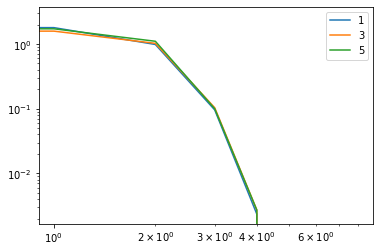

In [29]:
for lambd in range(6):
    if (pca.odd_pca_.pcas_[lambd]): #it can be None if input data doens't have any features for this lambda
        plt.plot(pca.odd_pca_.pcas_[lambd].singular_values_, label = str(lambd))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

There is one another compressor - InvariantsPCA. The only difference is that inputs and outputs are invariants. Now not both, only single parity.

In [30]:
pca = InvariantsPCA(n_components = 5, num_to_fit = '300x')
invariants_even = data_even_1.get_invariants()
print(invariants_even.shape)
pca.fit(invariants_even)
print(pca.transform(invariants_even).shape)

(500, 10)
(500, 5)


/home/pozdn/nice/nice/transformers/compressors.py:142: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 5, desired number of environments is 1500, actual number of environments is 500
  warnings.warn("Amount of provided data is less than the desired one to fit PCA. Number of components is {}, desired number of environments is {}, actual number of environments is {}".format(self.n_components, num_fit_now, X.shape[0]))


This inherits from sklearn.decomposition.PCA, thus it also has importance fields:

In [31]:
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))

[6.56740086e-01 3.32300866e-01 7.66021533e-03 3.29425638e-03
 4.57583355e-06]
0.9999999995966687


To deal with covariants and single parity there is class **IndividualLambdaPCAs**

## Expansioner

For thresholding expansion there is a class ThresholdExpansioner:

In [32]:
expansioner = ThresholdExpansioner(num_expand = 40)
expansioner.fit(data_even_1_t, data_odd_1_t, data_even_1_t, data_odd_1_t)
data_even_2, data_odd_2 = expansioner.transform(data_even_1_t, data_odd_1_t, data_even_1_t, data_odd_1_t)
print(data_even_2.covariants_.shape)
print(data_even_2.actual_sizes_)
print(data_odd_2.actual_sizes_)

(500, 34, 6, 11)
[16 15 33 26 34 23]
[ 0 24 20 34 26 30]


it operates with two even-odd pairs of covariants and produces clebsch-gordan product of them. I. e. if the body orders of the inputs are nu1 and nu2 output would be of body order nu1 + nu2.

As the main parameter it accepts num_expand and by binary search looks for such threshold to make number of pairs {<... l1 \*> <... l2 \*} be equal to num_expand. After that each such pair generates at most one feature to each lambda channel. (It depends on the values of l1 and l2 by triangle inequality) Thus the size of the output for different lambda channels is different. 



If num_expand is not specified it would do full expansion:

In [33]:
expansioner = ThresholdExpansioner()
expansioner.fit(data_even_1_t, data_odd_1_t, data_even_1_t, data_odd_1_t)
data_even_2, data_odd_2 = expansioner.transform(data_even_1_t, data_odd_1_t, data_even_1_t, data_odd_1_t)
print(data_even_2.covariants_.shape)
print(data_even_2.actual_sizes_)
print(data_odd_2.actual_sizes_)

(500, 1134, 6, 11)
[ 486  405 1053  810 1134  729]
[   0  810  648 1134  810  972]


Let's take invariants. 486 corresponds to 9 * 9 * (5 + 1). I. e. powerspectrum without it's symmetry with respect to changing the order of n1 and n2

Majority of the time in the fitting process takes calculation of clebsch-gordan coefficients. Thus, if we are planning to fit several expansioners it is good idea to calculate clebsch-gordan coefficients once:

In [34]:
clebsch = ClebschGordan(5)

In [35]:
expansioner = ThresholdExpansioner(num_expand = 40)
expansioner.fit(data_even_1_t, data_odd_1_t, data_even_1_t, data_odd_1_t, clebsch_gordan = clebsch)
data_even_2, data_odd_2 = expansioner.transform(data_even_1_t, data_odd_1_t, data_even_1_t, data_odd_1_t)
print(data_even_2.covariants_.shape)
print(data_even_2.actual_sizes_)
print(data_odd_2.actual_sizes_)

(500, 34, 6, 11)
[16 15 33 26 34 23]
[ 0 24 20 34 26 30]


At the last step it is not necessary to calcualte all covariants, it is enough to calculate only invariants. In order to achieve this one can pass mode = 'invariants':



In [36]:
expansioner = ThresholdExpansioner(num_expand = 40, mode = 'invariants')
expansioner.fit(data_even_1_t, data_odd_1_t, data_even_1_t, data_odd_1_t, clebsch_gordan = clebsch)
invariants_even, invariants_odd = expansioner.transform(data_even_1_t, data_odd_1_t, data_even_1_t, data_odd_1_t)
print(invariants_even.shape)
print(invariants_odd.shape)

(500, 41)
(500, 0)


It is usefull not only at the last step, because we most probably would want to calculate huge number of invariants at each step, which is computationally feasible, while calculation of the same amount of covariants is not. 

## Purifiers:

In [37]:
np.random.seed(0)
old_invariants = [np.random.rand(500, 20 + i * 5) for i in range(5)]
new_invariants = np.random.rand(500, 30)
pur = InvariantsPurifier()
pur.fit(old_invariants, new_invariants)
print(new_invariants.shape)
print(np.mean(new_invariants * new_invariants))
new_invariants_p = pur.transform(old_invariants, new_invariants)
print(new_invariants_p.shape)
print(np.mean(new_invariants_p * new_invariants_p))

(500, 30)
0.3347158597308048
(500, 30)
0.05837207039286959


/home/pozdn/nice/nice/transformers/purifiers.py:50: UserWarning: Amount of provided data is less than the desired one to fit InvariantsPurifer. Number of old features is 150, desired number of environments is 1500, actual number of environments is 500
  warnings.warn("Amount of provided data is less than the desired one to fit InvariantsPurifer. Number of old features is {}, desired number of environments is {}, actual number of environments is {}".format(total_num, num_fit_now, new_block.shape[0]))


parameters are num_to_fit, max_take and regressor. Behaviour of num_to_fit is the same as in case of compressors. Max_take determines amount of invariant to take from old ones. If it is None, that all previous invariants would be used for purification. If it is int than from each block no more than max_take invariants would be used. In this case invariants would be picked from the begining, assuming that previously you did something like pca transformation and invariants are sorted in the order to decaying importance. If you use this option it is your responsibility to assure this. If max_take is np.array of list than it is considered as the set of individual numbers to take from each block. 

In [38]:
np.random.seed(0)
old_invariants = [np.random.rand(500, 20 + i * 5) for i in range(5)]
new_invariants = np.random.rand(500, 30)
pur = InvariantsPurifier(max_take = 10)
pur.fit(old_invariants, new_invariants)
print(new_invariants.shape)
print(np.mean(new_invariants * new_invariants))
new_invariants_p = pur.transform(old_invariants, new_invariants)
print(new_invariants_p.shape)
print(np.mean(new_invariants_p * new_invariants_p))

(500, 30)
0.3347158597308048
(500, 30)
0.07542076163976533


regressor is the base linear regression class. Potentially with the parameters inside. Default is Ridge(alpha = 1e-12)

In [39]:
np.random.seed(0)
old_invariants = [np.random.rand(500, 20 + i * 5) for i in range(5)]
new_invariants = np.random.rand(500, 30)
pur = InvariantsPurifier(regressor = Ridge(alpha = 1e10))
pur.fit(old_invariants, new_invariants)
print(new_invariants.shape)
print(np.mean(new_invariants * new_invariants))
new_invariants_p = pur.transform(old_invariants, new_invariants)
print(new_invariants_p.shape)
print(np.mean(new_invariants_p * new_invariants_p))

(500, 30)
0.3347158597308048
(500, 30)
0.0834976296945275


/home/pozdn/nice/nice/transformers/purifiers.py:50: UserWarning: Amount of provided data is less than the desired one to fit InvariantsPurifer. Number of old features is 150, desired number of environments is 1500, actual number of environments is 500
  warnings.warn("Amount of provided data is less than the desired one to fit InvariantsPurifer. Number of old features is {}, desired number of environments is {}, actual number of environments is {}".format(total_num, num_fit_now, new_block.shape[0]))


In [40]:
from sklearn.linear_model import Lars
np.random.seed(0)
old_invariants = [np.random.rand(500, 20 + i * 5) for i in range(5)]
new_invariants = np.random.rand(500, 30)
pur = InvariantsPurifier(regressor = Lars())
pur.fit(old_invariants, new_invariants)
print(new_invariants.shape)
print(np.mean(new_invariants * new_invariants))
new_invariants_p = pur.transform(old_invariants, new_invariants)
print(new_invariants_p.shape)
print(np.mean(new_invariants_p * new_invariants_p))

/home/pozdn/nice/nice/transformers/purifiers.py:50: UserWarning: Amount of provided data is less than the desired one to fit InvariantsPurifer. Number of old features is 150, desired number of environments is 1500, actual number of environments is 500
  warnings.warn("Amount of provided data is less than the desired one to fit InvariantsPurifer. Number of old features is {}, desired number of environments is {}, actual number of environments is {}".format(total_num, num_fit_now, new_block.shape[0]))


(500, 30)
0.3347158597308048
(500, 30)
0.05847284067056952


Unfortunatelly BayesianRidge does not support multitarget regression. 

**CovariantsPurifierBoth** and **CovariantsPurifier** are the purifiers for covariants. Parameters are the same. In this case there is a subtle moment - you must not fit interecept, otherwise you would get non covariant transformtion since the vector of constants is not covariant. If you use custom regressor it is your responsibility to assure this. If you use regressor from sklearn you can set fit_intercept = False.

Using this blocks it is straightforward to do Nice, but I have couple of classes for convenience.

## StandardBlock

The typical unit of the nice is the set of 6 blocks. 1) first of all we need to do expansion of covariants. 2) we need to purify them. 3) we need to pca them. Potentially we want to do the same 4-6) with only invariants with much higher num_expand. The class StandardBlock corresponds to this transformation: 

In [41]:
'''def __init__(self, covariants_expansioner = None, covariants_purifier = None,
              covariants_pca = None, invariants_expansioner = None,
              invariants_purifier = None, invariants_pca = None, 
              guaranteed_parts_fitted_consistently = False)'''

'def __init__(self, covariants_expansioner = None, covariants_purifier = None,\n              covariants_pca = None, invariants_expansioner = None,\n              invariants_purifier = None, invariants_pca = None, \n              guaranteed_parts_fitted_consistently = False)'

It can be used for any partial task, i. e. if we would like to do small covariants expansion with subsequent purification and big invariants expansion without purification and with subsequent pca:

In [42]:
block = StandardBlock(ThresholdExpansioner(num_expand = 10), CovariantsPurifierBoth(), None,
                      ThresholdExpansioner(num_expand = 10000, mode = 'invariants'), None, InvariantsPCA(1000))


If expansioner is not set, than subsequent purification and pca has no sense, and thus it would raise and error:

In [43]:
block = StandardBlock(ThresholdExpansioner(num_expand = 10), CovariantsPurifierBoth(), None,
                      None, None, InvariantsPCA(1000))

ValueError: can not do pca over not existing invariants

but we can do only covariants, or only invariants:

In [44]:
block = StandardBlock(ThresholdExpansioner(num_expand = 10), CovariantsPurifierBoth(), None,
                      None, None, None)

In [45]:
'''def fit(self, first_even, first_odd, second_even, second_odd, 
            old_even_covariants = None, old_odd_covariants = None,
            old_even_invariants = None, clebsch_gordan = None):'''

'def fit(self, first_even, first_odd, second_even, second_odd, \n            old_even_covariants = None, old_odd_covariants = None,\n            old_even_invariants = None, clebsch_gordan = None):'

Fit method accepts two even-odd pairs and old covariants and invariants to fit purifiers. It purifiers present in init and no old data is given to fit it would rase Error.

In [46]:
''' def transform(self, first_even, first_odd, second_even, second_odd, old_even_covariants = None, old_odd_covariants = None,
            old_even_invariants = None):'''

' def transform(self, first_even, first_odd, second_even, second_odd, old_even_covariants = None, old_odd_covariants = None,\n            old_even_invariants = None):'

Transform method has the same input and it always returns covariants_even, covariants_odd, invariants_even. If covariants branch is absent it would return None, None, invariants_even. If invariants branch is absent it would return covariants_even, covariants_odd, None. (yep, invariants can be taken as covariants[:, :, 0, 0], and this is behavior of StandardSequence).

About guaranteed_parts_fitted_consistently = False later

## StandardSequence

The vanilla nice is the sequence of standard blocks, where each increase the body order by one. For this purpose I have class StandardSequence:

In [47]:
''' def __init__(self, blocks, 
initial_pca = None,
guaranteed_parts_fitted_consistently = False):'''

' def __init__(self, blocks, \ninitial_pca = None,\nguaranteed_parts_fitted_consistently = False):'

It accepts list with blocks, and initial_pca. InitialPCA is needed because input of each block should contain feature importances since the first action is to do expansion. By default (None) it is IndividualLambdaPCAsBoth(), i. e. it doesn't do any reduction

Example of the usage:

In [48]:
from sklearn.linear_model import Ridge, Lasso, Lars, LassoLars

transformer = StandardSequence([StandardBlock(ThresholdExpansioner(200),
                                             None,
                                             IndividualLambdaPCAsBoth(50),
                                             ThresholdExpansioner(500, mode = 'invariants'),
                                             None,
                                             None),
                                StandardBlock(ThresholdExpansioner(100),
                                             CovariantsPurifierBoth(max_take = 10),
                                             IndividualLambdaPCAsBoth(75),
                                             ThresholdExpansioner(500, mode = 'invariants'),
                                             None,
                                             InvariantsPCA(200)),
                                StandardBlock(ThresholdExpansioner(100),
                                             CovariantsPurifierBoth(regressor = Ridge(alpha = 1e5, fit_intercept = False), max_take = 20),
                                             IndividualLambdaPCAsBoth(),
                                             ThresholdExpansioner(500, mode = 'invariants'),
                                             InvariantsPurifier(regressor = Lars(n_nonzero_coefs = 10), max_take = 20),
                                             None),
                                StandardBlock(ThresholdExpansioner(100),
                                             CovariantsPurifierBoth(regressor = Lasso(alpha=17.0, fit_intercept = False), max_take = 20),
                                             IndividualLambdaPCAsBoth(),
                                             ThresholdExpansioner(500, mode = 'invariants'),
                                             InvariantsPurifier(regressor = LassoLars(alpha = 1e-5), max_take = 20),
                                             None),
                               StandardBlock(None,
                                             None,
                                             None,
                                             ThresholdExpansioner(5000, mode = 'invariants'),
                                             None,
                                             None)])

I. e. this way to define a model is very flexible and at the same time compact. Note also that some linear regressors constructs sparse model, i. e. Lasso. If these estimators use in their internal transform method this sparsity to speed up the prediction(I have not investigated it yet)  it would immediatelly result that the nice transformer would also benefit from it. It also should be noted that Invariant purifiers always use covariants[:, :, 0, 0] as invariants even if invariants branch of corresponding standard block is presented. It is done to not to fuck up with max_take parameter - covariants are always guaranteed to be pca-ed, and thus are always sorted in the order of decaying importance, while invariants can be not.

Let's fit it:

In [49]:
begin = time.time()
transformer.fit(coefficients[6][0:1000])
print(time.time() - begin)

/home/pozdn/nice/nice/transformers/compressors.py:73: RuntimeWarning: given data is less than desired number of points to fit pca. Desired number of points to fit pca is 750, while number of vectors is 500, dimensionality of single vector (lambd + 1) is 1, i. e. total number of points is 500. Number of pca components is 75
  warnings.warn("given data is less than desired number of points to fit pca. Desired number of points to fit pca is {}, while number of vectors is {}, dimensionality of single vector (lambd + 1) is {}, i. e. total number of points is {}. Number of pca components is {}".format(num_fit_now, data.covariants_.shape[0], (lambd + 1), data.covariants_.shape[0] * (lambd + 1), n_components_now), RuntimeWarning)
/home/pozdn/nice/nice/transformers/compressors.py:73: RuntimeWarning: given data is less than desired number of points to fit pca. Desired number of points to fit pca is 750, while number of vectors is 500, dimensionality of single vector (lambd + 1) is 1, i. e. total

14.377447366714478


Now we can transform the data:

In [50]:
last_even, last_odd, invariants_even = transformer.transform(coefficients[6][0:100])

It always return even-odd pair of covariants after the last block and all even invariants. In our case covariants are absent because last block doesn't calcualte them

In [51]:
print(last_even, last_odd)

None None


Invariants is the dictionary with the keys corresponding to body order:

In [52]:
print(invariants_even.keys())

dict_keys([1, 2, 3, 4, 5, 6])


In [53]:
for nu in invariants_even.keys():
    print("shape of invariants for nu = {} : {}".format(nu, invariants_even[nu].shape))

shape of invariants for nu = 1 : (100, 10)
shape of invariants for nu = 2 : (100, 600)
shape of invariants for nu = 3 : (100, 200)
shape of invariants for nu = 4 : (100, 501)
shape of invariants for nu = 5 : (100, 513)
shape of invariants for nu = 6 : (100, 2980)


We can put return_only_invariants = True to the transform method to get only invariants:

In [54]:
invariants = transformer.transform(coefficients[6][0:100], return_only_invariants = True)
print(type(invariants))

<class 'dict'>


Parallelization is done internally. For the best performance it is necessary to call transform method with big chunks of data:

In [55]:
structures = ase_io.read('structures.xyz', 
                         index = '0:10000')

process_structures(structures, 100)

#process_structures(structures_val)
HYPERS = {
'interaction_cutoff': 6.3,
'max_radial': 5,
'max_angular': 5,
'gaussian_sigma_type': 'Constant',
'gaussian_sigma_constant': 0.05,
'cutoff_smooth_width': 0.3,
'radial_basis': 'GTO'
}
coefficients = get_rascal_coefficients_parallelized(structures, HYPERS)
normalize_coefficients(coefficients)
print(coefficients[1].shape)
print(coefficients[6].shape)

100%|██████████| 2/2 [00:00<00:00, 21.27it/s]


(40000, 10, 6, 11)
(10000, 10, 6, 11)


In [56]:
nums = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
for num in nums:
    begin = time.time()
    _ = transformer.transform(coefficients[6][0:num], return_only_invariants = True)
    time_now = time.time() - begin
    print("n environments: {}, total time: {}, time per environment: {}".format(num, time_now, time_now / num))

n environments: 1, total time: 0.021955013275146484, time per environment: 0.021955013275146484
n environments: 2, total time: 0.01876354217529297, time per environment: 0.009381771087646484
n environments: 5, total time: 0.021266937255859375, time per environment: 0.004253387451171875
n environments: 10, total time: 0.02413630485534668, time per environment: 0.002413630485534668
n environments: 20, total time: 0.03394031524658203, time per environment: 0.0016970157623291016
n environments: 50, total time: 0.04782986640930176, time per environment: 0.0009565973281860352
n environments: 100, total time: 0.08362770080566406, time per environment: 0.0008362770080566406
n environments: 200, total time: 0.2048969268798828, time per environment: 0.001024484634399414
n environments: 500, total time: 0.6155490875244141, time per environment: 0.0012310981750488282
n environments: 1000, total time: 1.3157145977020264, time per environment: 0.0013157145977020263
n environments: 2000, total time: 

We can access importances_ in the pca the same way as before: (I renamed transformer to c_trans because I copied this part of code from the other notebook with c_trans)

nu:  1


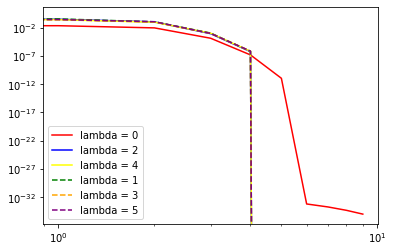

nu:  2


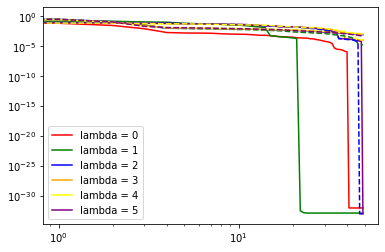

nu:  3


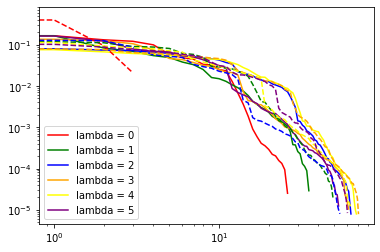

nu:  4


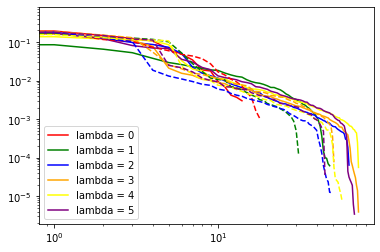

nu:  5


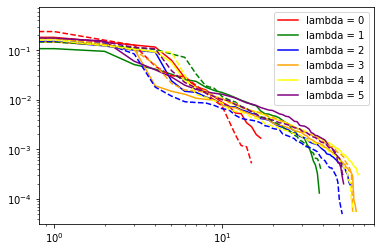

No handles with labels found to put in legend.


nu:  6


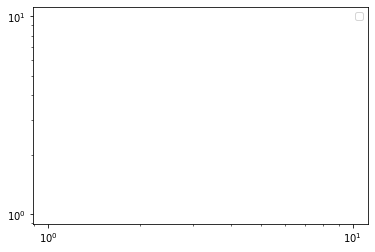

In [57]:
c_trans = transformer
colors = ['r', 'g', 'b', 'orange', 'yellow', 'purple']

print("nu: ", 1)
for i in range(6):
    if (c_trans.initial_pca_ is not None):
        if (c_trans.initial_pca_.even_pca_.pcas_[i] is not None):
            plt.plot(c_trans.initial_pca_.even_pca_.pcas_[i].importances_, color = colors[i], label = "lambda = {}".format(i))


for i in range(6):
    if (c_trans.initial_pca_ is not None):
        if (c_trans.initial_pca_.odd_pca_.pcas_[i] is not None):
            plt.plot(c_trans.initial_pca_.odd_pca_.pcas_[i].importances_, '--', color = colors[i], label = "lambda = {}".format(i))

plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()
    
for nu in range(len(c_trans.blocks_)):
    print("nu: ", nu + 2)
    for i in range(6):
        if (c_trans.blocks_[nu].covariants_pca_ is not None):
            if (c_trans.blocks_[nu].covariants_pca_.even_pca_.pcas_[i] is not None):
                plt.plot(c_trans.blocks_[nu].covariants_pca_.even_pca_.pcas_[i].importances_, color = colors[i], label = "lambda = {}".format(i))
        
    
    for i in range(6):
        if (c_trans.blocks_[nu].covariants_pca_ is not None):
            if (c_trans.blocks_[nu].covariants_pca_.odd_pca_.pcas_[i] is not None):
                plt.plot(c_trans.blocks_[nu].covariants_pca_.odd_pca_.pcas_[i].importances_, '--', color = colors[i])
    
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.show()

Lines may be weird because of random parameters. And the last plot is absent because last block doesn't calculate covariants.

As we noticed before actual number of components is different for different lambda. And we might be interested in it at every step of transformations. We can achieve it by calling get_intermediate_shape() method:

In [58]:
intermediate_shapes = transformer.get_intermediate_shapes()
print(type(intermediate_shapes))

<class 'dict'>


It is nested dictionary:

In [59]:
for key in intermediate_shapes.keys():
    print(key, ':',  intermediate_shapes[key], end = '\n\n\n')

after initial transformer : [[10, 0, 10, 0, 10, 0], [0, 10, 0, 10, 0, 10]]


after initial pca : [[10, 0, 10, 0, 10, 0], [0, 10, 0, 10, 0, 10]]


block nu = 1 -> nu = 2 : {'after covariants expansioner': [[65, 59, 149, 116, 162, 107], [0, 114, 94, 164, 118, 138]], 'after covariants pca': [[50, 50, 50, 50, 50, 50], [0, 50, 50, 50, 50, 50]], 'after invariants expansioner': 600}


block nu = 2 -> nu = 3 : {'after covariants expansioner': [[27, 36, 64, 62, 69, 54], [4, 50, 55, 71, 64, 61]], 'after covariants purifier': [[27, 36, 64, 62, 69, 54], [4, 50, 55, 71, 64, 61]], 'after covariants pca': [[27, 36, 64, 62, 69, 54], [4, 50, 55, 71, 64, 61]], 'after invariants expansioner': 501, 'after invariants pca': 200}


block nu = 3 -> nu = 4 : {'after covariants expansioner': [[15, 49, 64, 73, 73, 69], [19, 32, 50, 52, 58, 46]], 'after covariants purifier': [[15, 49, 64, 73, 73, 69], [19, 32, 50, 52, 58, 46]], 'after covariants pca': [[15, 49, 64, 73, 73, 69], [19, 32, 50, 52, 58, 46]], 'after i

For next feature let's take some not so crazy parameters:

In [60]:
transformer = StandardSequence([StandardBlock(ThresholdExpansioner(500),
                                             None,
                                             IndividualLambdaPCAsBoth(200),
                                             None,
                                             None,
                                             None),
                                StandardBlock(ThresholdExpansioner(500),
                                             CovariantsPurifierBoth(max_take = 20),
                                             IndividualLambdaPCAsBoth(200),
                                             None,
                                             None,
                                             None),
                                StandardBlock(None,
                                             None,
                                             None,
                                             ThresholdExpansioner(500, mode = 'invariants'),
                                             None,
                                             None),
                                ])

print(coefficients[6].shape)
begin = time.time()
transformer.fit(coefficients[6][0:1000])
print(time.time() - begin)

(10000, 10, 6, 11)


/home/pozdn/nice/nice/transformers/compressors.py:73: RuntimeWarning: given data is less than desired number of points to fit pca. Desired number of points to fit pca is 2000, while number of vectors is 1000, dimensionality of single vector (lambd + 1) is 1, i. e. total number of points is 1000. Number of pca components is 200
  warnings.warn("given data is less than desired number of points to fit pca. Desired number of points to fit pca is {}, while number of vectors is {}, dimensionality of single vector (lambd + 1) is {}, i. e. total number of points is {}. Number of pca components is {}".format(num_fit_now, data.covariants_.shape[0], (lambd + 1), data.covariants_.shape[0] * (lambd + 1), n_components_now), RuntimeWarning)
/home/pozdn/nice/nice/transformers/compressors.py:73: RuntimeWarning: given data is less than desired number of points to fit pca. Desired number of points to fit pca is 2000, while number of vectors is 1000, dimensionality of single vector (lambd + 1) is 1, i. e.

10.23989748954773


In [61]:
invariants_even = transformer.transform(coefficients[6][0:1000], return_only_invariants = True)

One another feature - at the last step we have block which calculates a lot of invariants without pca and purifier. We can access its "raw importances" which are given by the multiplication of source covariants importances in the ThresholdExpansioner.

In [62]:
raw_importances = transformer.blocks_[-1].invariants_expansioner_.new_even_raw_importances_
print(raw_importances.shape)
print(invariants_even[4].shape)

(504,)
(1000, 504)


Let's do the following plot - on the x axis sqrt of raw importances (since they are multiplication of importances, i. e. multiplication of previous variances), and on the y axis real variance:

In [63]:
variances = np.mean(((invariants_even[4] - np.mean(invariants_even[4], axis= 0)) ** 2), axis = 0)
print(variances.shape)

(504,)


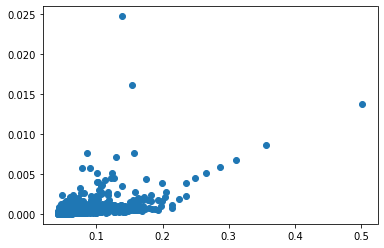

In [64]:
plt.plot(np.sqrt(raw_importances), variances, 'o')

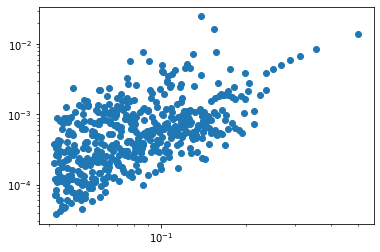

In [65]:
plt.plot(np.sqrt(raw_importances), variances, 'o')
plt.xscale('log')
plt.yscale('log')

There is some correlation, thresholding works somehow. Raw importances can be used for example to do the countoplot of rmse depending on 1) number of invariants to calculate and 2) number of invariants to keep with pca in single run of StandardSequence - just calculate the maximum amount of invarinats in the last block, and after that choose invariants to be pca-ed in the order of decreasing raw importances. 

StandardSequence checks if some intermediate block doesn't return covariants with importances_ (i. e. covariants pca is necessary) and raises error in this case. 

In [66]:
from sklearn.linear_model import Ridge, Lasso, Lars, LassoLars

transformer = StandardSequence([StandardBlock(None,
                                             None,
                                             None,
                                             ThresholdExpansioner(500, mode = 'invariants'),
                                             None,
                                             None),
                                StandardBlock(ThresholdExpansioner(100),
                                             CovariantsPurifierBoth(max_take = 10),
                                             IndividualLambdaPCAsBoth(75),
                                             ThresholdExpansioner(500, mode = 'invariants'),
                                             None,
                                             InvariantsPCA(200)),
                                ])


ValueError: all intermediate standard blocks should calculate covariants

In [67]:
from sklearn.linear_model import Ridge, Lasso, Lars, LassoLars

transformer = StandardSequence([StandardBlock(ThresholdExpansioner(100),
                                             None,
                                             None,
                                             ThresholdExpansioner(500, mode = 'invariants'),
                                             None,
                                             None),
                                StandardBlock(ThresholdExpansioner(100),
                                             CovariantsPurifierBoth(max_take = 10),
                                             IndividualLambdaPCAsBoth(75),
                                             ThresholdExpansioner(500, mode = 'invariants'),
                                             None,
                                             InvariantsPCA(200)),
                                ])


ValueError: all intermediate standard blocks should calculate covariants

## Custom regressors into purifiers

Let's say we need some regressor which is not listed in sklearn.linear_model. Not a problem we can implement it ourselves. Let's say we need purifier based on Ridge, which would determine best alpha by the cross validation on the training set:

In [68]:
from sklearn.model_selection import cross_val_predict

class AdaptiveRidge:
    def __init__(self):
        pass
    
    def fit(self, X, y):
        minimum = None
        self.best_alpha_ = None
        for alpha in np.logspace(-25, 10, 300):
            clf = Ridge(alpha = alpha, fit_intercept = False)
            predictions = cross_val_predict(clf, X, y)            
            now = np.mean((predictions - y) ** 2)
            if (minimum is None) or (now < minimum):
                minimum = now
                self.best_alpha_ = alpha
            
        self.ridge_ = Ridge(alpha = self.best_alpha_, fit_intercept = False)
        self.ridge_.fit(X, y)
        
    def predict(self, X):
        return self.ridge_.predict(X)
    
    def get_params(self, deep=True):        
        return {}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

It has two additonal methods get_params and set_params. It is because my implementation is based on sklearn.base.clone function (https://scikit-learn.org/stable/modules/generated/sklearn.base.clone.html). And thus all classes should obey some requirements to make it work. See section cloning here https://scikit-learn.org/stable/developers/develop.html. 

Let's run it:

In [69]:
transformer = StandardSequence([StandardBlock(ThresholdExpansioner(100),
                                             None,
                                             IndividualLambdaPCAsBoth(15),
                                             ThresholdExpansioner(500, mode = 'invariants'),
                                             None,
                                             None),
                                StandardBlock(ThresholdExpansioner(100),
                                             CovariantsPurifierBoth(regressor = AdaptiveRidge(), max_take = 10),
                                             IndividualLambdaPCAsBoth(75),
                                             ThresholdExpansioner(500, mode = 'invariants'),
                                             None,
                                             InvariantsPCA(50)),
                                ])
begin = time.time()
transformer.fit(coefficients[6][0:100])
print(time.time() - begin)
begin = time.time()
res = transformer.transform(coefficients[6][0:100])
print(time.time() - begin)

/home/pozdn/nice/nice/transformers/compressors.py:73: RuntimeWarning: given data is less than desired number of points to fit pca. Desired number of points to fit pca is 150, while number of vectors is 100, dimensionality of single vector (lambd + 1) is 1, i. e. total number of points is 100. Number of pca components is 15
  warnings.warn("given data is less than desired number of points to fit pca. Desired number of points to fit pca is {}, while number of vectors is {}, dimensionality of single vector (lambd + 1) is {}, i. e. total number of points is {}. Number of pca components is {}".format(num_fit_now, data.covariants_.shape[0], (lambd + 1), data.covariants_.shape[0] * (lambd + 1), n_components_now), RuntimeWarning)
/home/pozdn/nice/nice/transformers/purifiers.py:121: UserWarning: Amount of provided data is less than the desired one to fit InvariantsPurifer. Number of old features is 20, desired number of data points is 200, actual number of data points (n_env * (l + 1)) is 100, 

/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.28377e-25): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.28822e-25): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.86501e-25): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.86977e-25): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.8548e-25): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/

/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.94282e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.94529e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.8235e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.82615e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.81781e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/

/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.63901e-17): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.64039e-17): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.12951e-17): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.13099e-17): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.12635e-17): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib

/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46341e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.97386e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.97854e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.06366e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.03485e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib

/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.8054e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.75082e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.11203e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.37851e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.39014e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/

/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.39817e-17): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.40038e-17): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.44039e-17): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.42685e-17): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.51647e-17): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib

/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.19984e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.2357e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.15493e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.27367e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.15104e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/

/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.23647e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.08343e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.30843e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.97099e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.45808e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib

/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.0278e-18): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.73779e-18): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.16416e-18): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.13146e-17): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.03426e-17): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/

/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.29968e-27): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.40091e-27): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.37728e-27): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.35177e-27): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.525e-27): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/p

/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.47582e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.41721e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.3539e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.78373e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.22224e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/

/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.62395e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.47853e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.32145e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.3879e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.04759e-20): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/

/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.10363e-17): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.06466e-17): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.32926e-17): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.5992e-17): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.80164e-17): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/

/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.61989e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26864e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.93955e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.09308e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.10036e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib

/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.06957e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.29891e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.67529e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.96622e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.98003e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib

/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.81661e-18): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.14611e-18): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.9644e-18): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.5157e-18): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.54186e-18): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/p

/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.30645e-27): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.20829e-27): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.22127e-27): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.30136e-27): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.33277e-27): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib

/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.47562e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.28961e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31421e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46599e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.52551e-24): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib

/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.65497e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.69111e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.33864e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.38524e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.67286e-21): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib

/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.76266e-18): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.92589e-18): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.88929e-18): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.2214e-18): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.30971e-18): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/psi4conda/lib/

/home/pozdn/nice/nice/transformers/compressors.py:73: RuntimeWarning: given data is less than desired number of points to fit pca. Desired number of points to fit pca is 750, while number of vectors is 100, dimensionality of single vector (lambd + 1) is 1, i. e. total number of points is 100. Number of pca components is 75
  warnings.warn("given data is less than desired number of points to fit pca. Desired number of points to fit pca is {}, while number of vectors is {}, dimensionality of single vector (lambd + 1) is {}, i. e. total number of points is {}. Number of pca components is {}".format(num_fit_now, data.covariants_.shape[0], (lambd + 1), data.covariants_.shape[0] * (lambd + 1), n_components_now), RuntimeWarning)
/home/pozdn/nice/nice/transformers/compressors.py:73: RuntimeWarning: given data is less than desired number of points to fit pca. Desired number of points to fit pca is 375, while number of vectors is 100, dimensionality of single vector (lambd + 1) is 2, i. e. total

25.189939737319946
0.08280277252197266


Fitting takes a lot of time, but prediction is still okay. Let's look at the resulting best alpha:

In [71]:
for lambd in range(6):
    if (transformer.blocks_[1].covariants_purifier_.even_purifier_.purifiers_[lambd]):
        print("even ", lambd, transformer.blocks_[1].covariants_purifier_.even_purifier_.purifiers_[lambd].regressor_.best_alpha_)
    if (transformer.blocks_[1].covariants_purifier_.odd_purifier_.purifiers_[lambd]):
        print("odd ", lambd, transformer.blocks_[1].covariants_purifier_.odd_purifier_.purifiers_[lambd].regressor_.best_alpha_)

even  0 0.015040335536380345
even  1 0.0004523956232538058
odd  1 0.17012542798525995
even  2 0.011486842567375548
odd  2 0.019693113379074298
even  3 0.04420637972028548
odd  3 0.00511717300711461
even  4 0.002279604637318982
odd  4 0.025785243528842764
even  5 0.025785243528842764
odd  5 2.3874067718606566e-07


It is inconvenient to access them, but it is not designed to, and it is not expected that users would do it often.  For properties such as explained_variance_ in the pca I am planing to add getters

## Sequential fitting

It may be usefull to fit blocks sequentially, deciding which hypers to take for the next block based on the results of previous block. After that we would like to pack blocks into the StandardSequence to have convenient transform method. Let's do it:

In [72]:
even_0, odd_0 = InitialTransformer().transform(coefficients[6][0:100])

In [73]:
initial_pca = IndividualLambdaPCAsBoth()
initial_pca.fit(even_0, odd_0)
even_0_t, odd_0_t = initial_pca.transform(even_0, odd_0)

In [74]:
block_1 = StandardBlock(ThresholdExpansioner(100), None, IndividualLambdaPCAsBoth(20))

In [75]:
block_1.fit(even_0_t, odd_0_t, even_0_t, odd_0_t)

/home/pozdn/nice/nice/transformers/compressors.py:73: RuntimeWarning: given data is less than desired number of points to fit pca. Desired number of points to fit pca is 200, while number of vectors is 100, dimensionality of single vector (lambd + 1) is 1, i. e. total number of points is 100. Number of pca components is 20
  warnings.warn("given data is less than desired number of points to fit pca. Desired number of points to fit pca is {}, while number of vectors is {}, dimensionality of single vector (lambd + 1) is {}, i. e. total number of points is {}. Number of pca components is {}".format(num_fit_now, data.covariants_.shape[0], (lambd + 1), data.covariants_.shape[0] * (lambd + 1), n_components_now), RuntimeWarning)


In [76]:
even_1, odd_1, _ = block_1.transform(even_0_t, odd_0_t, even_0_t, odd_0_t)

In [77]:
block_2 = StandardBlock(None, None, None, ThresholdExpansioner(100, mode = 'invariants'))

In [78]:
block_2.fit(even_1, odd_1, even_0_t, odd_0_t)

In [79]:
_, _, even_invariants = block_2.transform(even_1, odd_1, even_0_t, odd_0_t)

So, we have fitted all the parts, now let's construct StandardSequence:

In [80]:
trans = StandardSequence(initial_pca= initial_pca, blocks = [block_1, block_2])
_, _, even_invariants_new = trans.transform(coefficients[6][0:100])

NotFittedError: instance of StandardSequence is not fitted. It can not transform anything

Oops, it tells that it is not fitted. The issue is that we need to specify one additional parameter in the init -guaranteed_parts_fitted_consistently. It is done for the purpose to make user do such constructions responsibly, because at this point there are a lot of potential bugs, where we would construct StandardSequence from fitted parts, but from fitted inconsistently - i. e. Purifier fitted to purify nu = 10 covariants, and pca to compress nu = 7 covariants. 

StandardSequence is considered to be fitted if all parts are fitted and if guaranteed_parts_fitted_consistently set to be True

In [81]:
trans = StandardSequence(initial_pca= initial_pca, blocks = [block_1, block_2], 
                         guaranteed_parts_fitted_consistently=True)
_, _, even_invariants_new = trans.transform(coefficients[6][0:100])

In [82]:
print(even_invariants_new.keys())

dict_keys([1, 2, 3])


In [83]:
print(even_invariants[0, 0:5])
print(even_invariants_new[3][0, 0:5])

[ 2.01247343 -0.1257774  -0.16815822 -0.23461774 -0.0047428 ]
[ 2.01247343 -0.1257774  -0.16815822 -0.23461774 -0.0047428 ]


The same is related to StandardBlock. It is considered as fitted if 1) all parts are fitted and 2) if guaranteed_parts_fitted_consistently set to be True

It can also work in the other direction:

In [84]:
initial_pca = IndividualLambdaPCAsBoth()
block_1 = StandardBlock(ThresholdExpansioner(100), None, IndividualLambdaPCAsBoth(20))
block_2 = StandardBlock(None, None, None, ThresholdExpansioner(100, mode = 'invariants'))

In [85]:
print(initial_pca.is_fitted())
print(block_1.is_fitted())
print(block_2.is_fitted())

False
False
False


In [ ]:
trans = StandardSequence(initial_pca = initial_pca, blocks = [block_1, block_2])
trans.fit(coefficients[6][0:100])

/home/pozdn/nice/nice/transformers/compressors.py:73: RuntimeWarning: given data is less than desired number of points to fit pca. Desired number of points to fit pca is 200, while number of vectors is 100, dimensionality of single vector (lambd + 1) is 1, i. e. total number of points is 100. Number of pca components is 20
  warnings.warn("given data is less than desired number of points to fit pca. Desired number of points to fit pca is {}, while number of vectors is {}, dimensionality of single vector (lambd + 1) is {}, i. e. total number of points is {}. Number of pca components is {}".format(num_fit_now, data.covariants_.shape[0], (lambd + 1), data.covariants_.shape[0] * (lambd + 1), n_components_now), RuntimeWarning)


In [ ]:
print(initial_pca.is_fitted())
print(block_1.is_fitted())
print(block_2.is_fitted())

But the other direction will not work in case of linear regressor passed to CovariantsPurifier and CovariantsPurifierBoth. Indeed, these classes need several different instances of linear regressor for different lambda chaneels. So they are based on sklearn.base.clone (https://scikit-learn.org/stable/modules/generated/sklearn.base.clone.html), and do not touch initial instance in any way. 